In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
con = sqlite3.connect(":memory:")
cur = con.cursor()

In [4]:
df_ratings = pd.read_csv("E:/git_exercise/Final/edges/rec-libimseti-dir.edges", delim_whitespace=True, skiprows=1, names=["id_from", "id_to", "rating"])

In [5]:
# создаем таблицу
df_ratings.to_sql('ratings', con, index=False, if_exists='replace')

17359346

In [6]:
# считываем  датасет info
df_info = pd.read_csv('E:/git_exercise/Final/edges/info.csv', names=["id", "gender", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])

C:\Users\albom\AppData\Local\Temp\ipykernel_1132\3540005613.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_info = pd.read_csv('E:/git_exercise/Final/edges/info.csv', names=["id", "gender", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])


In [7]:
#создаем таблицу
df_info.to_sql('info', con, index=False, if_exists='replace')

220971

In [8]:
data=pd.read_sql(
    '''
    SELECT r.id_from,i.gender,r.id_to,r.rating FROM info i
    join ratings r on r.id_from=i.id order by r.id_from
    ''',
    con,
)

In [9]:
data

,id_from,gender,id_to,rating
0,1,F,133,8
1,1,F,720,6
2,1,F,971,10
3,1,F,1095,7
4,1,F,1616,10
...,...,...,...,...
17359341,135359,F,215145,8
17359342,135359,F,215718,4
17359343,135359,F,218646,10
17359344,135359,F,218857,7


In [10]:
#Статистика датасета по полу
df_info['gender'].value_counts()

gender
U          83164
M          76441
F          61365
 gender        1
Name: count, dtype: int64

In [11]:
#Находим средние значения рейтинга для каждуого лайкнутого пользователя
mean_ratings_to=pd.DataFrame(df_ratings.groupby('id_to')['rating'].mean())

In [12]:
# Считаем число оценок лайкнутых пользователей
mean_ratings_to['number of rating'] = pd.DataFrame(df_ratings.groupby('id_to')['rating'].count())

In [13]:
# Теперь те же два действия для лайкнувших пользователей
mean_ratings_from =pd.DataFrame(df_ratings.groupby('id_from')['rating'].mean())

In [14]:
mean_ratings_from['number of rating'] = pd.DataFrame(df_ratings.groupby('id_from')['rating'].count())

In [15]:
#Выбираем активно лайкавших пользователей (кто оценил более, например, 200 раз)
new_meanrate_from = mean_ratings_from[mean_ratings_from['number of rating'] > 200]

In [17]:
#Сохранение индексов
index_from = new_meanrate_from.index

In [18]:
# Теперь те же два действия для лайкнутых пользователей
new_meanrate_to = mean_ratings_to[mean_ratings_to['number of rating'] > 300 ]
index_to = new_meanrate_to.index

In [19]:
# Делаем сэмпл, где где 'id_from' совпадает с одним из индексов в 'index_from', и 'id_to' совпадает с одним из индексов в 'index_to'
df_ratings_sample = df_ratings.loc[(df_ratings['id_from'].isin(index_from)) & (df_ratings['id_to'].isin(index_to))]

In [20]:
# Сократили размер с 17+ млн до 4,7 млн записей
df_ratings_sample.shape

(4738218, 3)

In [21]:
#Уникальные id в столбцах
df_ratings_sample['id_from'].nunique(), df_ratings_sample['id_to'].nunique()

(15874, 12459)

In [22]:
#Так же, как и выше, находим средние значения и число оценок, но уже в сэмпле
mean_ratings_to = pd.DataFrame(df_ratings_sample.groupby('id_to')['rating'].mean())
mean_ratings_to['number of rating'] = pd.DataFrame(df_ratings_sample.groupby('id_to')['rating'].count())
mean_ratings_from =pd.DataFrame(df_ratings_sample.groupby('id_from')['rating'].mean())
mean_ratings_from['number of rating'] = pd.DataFrame(df_ratings_sample.groupby('id_from')['rating'].count())

Визуализация:

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

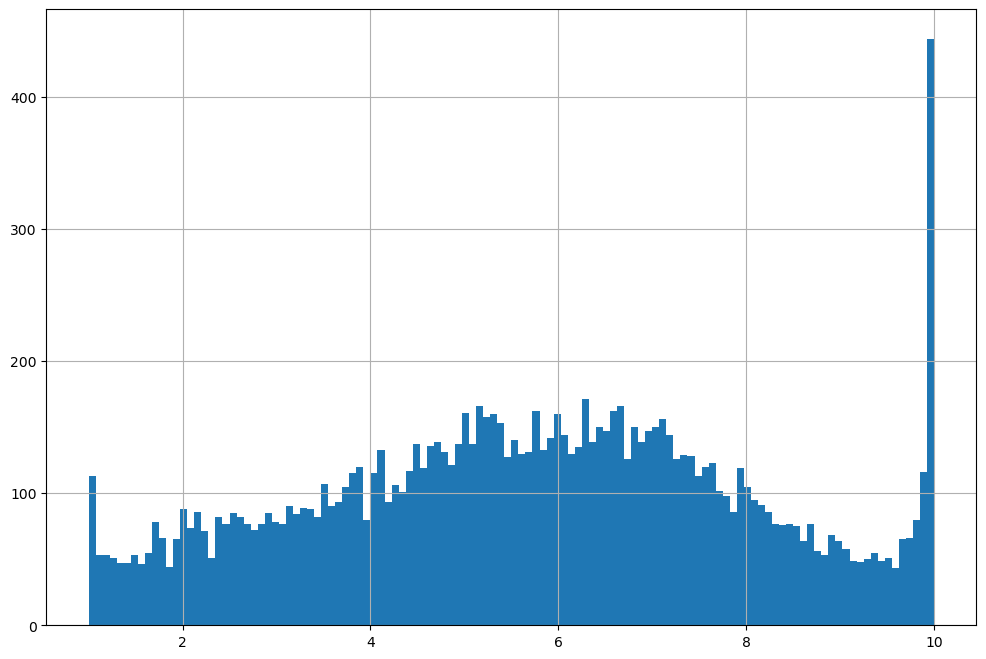

In [24]:
plt.figure(figsize=(12,8))
mean_ratings_to['rating'].hist(bins=120)

По графику, есть два пика: большое число пользователей, которых оценили по максимуму (10) и меньшее, но тоже выделяющееся - кого оценили минимально (1). Остальные, в целом, укладываются в нормальное распределение.

In [25]:
#Сортируем по убыванию
mean_ratings_to['number of rating'].sort_values(ascending=False).head()

id_to
68989     7104
83773     6959
156148    6887
179192    6426
155380    5899
Name: number of rating, dtype: int64

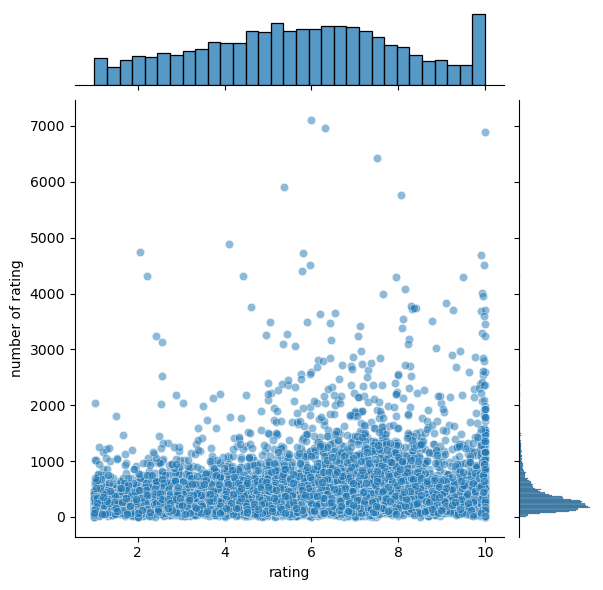

In [26]:
# Строим совместный график
sns.jointplot(x='rating',y='number of rating',data=mean_ratings_to,alpha=0.5)

Наибольшее количество оценок у пользователей с рейтингами 6-8 и 10

Возьмем два основных метода: 
1.Popularity based recommendation 
2.Content based recommendation 

In [28]:
#Popularity based recommendation выведет рекомендованных пользователей, которые высоко оценивались чаще всего 
#(в нашем случае, рейтинг выше 6)
df_to = mean_ratings_to.sort_values(['number of rating','rating'],ascending=[False,False])
df_to.head()

,rating,number of rating
id_to,,
68989,5.988035,7104
83773,6.318293,6959
156148,9.996370,6887
179192,7.521008,6426
155380,5.371588,5899


In [30]:
len(mean_ratings_to[(mean_ratings_to['number of rating'] > 10000) & (mean_ratings_to['rating'] > 6)])

0

In [33]:
#Defining Popularity Based Model
def popular_recommend_model(id_from,df_to,threshold,k):
  """
Этот код возвращает верхние 'k' профилей на основе самого высокого рейтинга и количества рейтингов, 
превышающих определенный порог, независимо от идентификатора пользователя. 
Если значение k больше, чем количество профилей, соответствующих критериям, 
он просто возвращает максимальное количество профилей, соответствующих критериям.
  """
 # try:
#   if len(profile_df[(profile_df['number of rating'] > threshold) & (profile_df['Rating'] > 6)]) < 1:
#     print("Your filtering doesn't match any profiles")
  return (df_to[(df_to['number of rating'] > threshold) & (df_to['rating'] > 6)].head(k).index)
 # except:
 #   print("Index out of range")

In [37]:
popular_recommend_model(98447,mean_ratings_to,2500,10)

Index([328, 1029, 1561, 5962, 6036, 6437, 7006, 10148, 12513, 14258], dtype='int64', name='id_to')

In [38]:
#2. Content- Based Recommendation
'''
Этот код проверит сходство профилей на основе различных скрытых признаков и предложит профили, 
похожие на те, которые были оценены пользователем ранее, 
создав матрицу профиля, в которой пользователь будет использоваться в качестве индекса, 
профиль - в качестве столбца, а их рейтинг - в качестве значений.
'''
profilemat = df_ratings_sample.pivot_table(index='id_from',columns='id_to',values='rating')

In [39]:
profilemat.index

Index([     1,      9,     18,     31,     38,     55,     60,     65,     73,
           74,
       ...
       135280, 135281, 135285, 135298, 135334, 135337, 135339, 135350, 135357,
       135359],
      dtype='int64', name='id_from', length=15874)

In [40]:
profilemat.head()

id_to,42,55,57,58,77,84,90,132,133,175,...,220760,220782,220788,220840,220848,220859,220861,220900,220950,220953
id_from,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Например, пользователь 1 лайкнул пользователя 133 (рейтинг 8). Находим сходство других профилей с id 133, это считается фильтрацией на основе контента/

In [41]:
ratings_to_X = profilemat[133]
ratings_to_X.head()

id_from
1     8.0
9     NaN
18    NaN
31    NaN
38    NaN
Name: 133, dtype: float64

In [42]:
similarto_to_X = profilemat.corrwith(ratings_to_X)

E:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
E:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


In [43]:
similarto_to_X.head()

id_to
42         NaN
55    0.089898
57   -0.047830
58         NaN
77         NaN
dtype: float64

In [44]:
corr_to_X = pd.DataFrame(similarto_to_X,columns=['Correlation'])
corr_to_X.dropna(inplace=True)
corr_to_X.head()

,Correlation
id_to,
55,0.089898
57,-0.047830
84,0.463969
133,1.000000
181,1.000000


In [45]:
corr_to_X.sort_values('Correlation',ascending=False).head(10)

,Correlation
id_to,
3246,1.0
143924,1.0
6674,1.0
124106,1.0
124059,1.0
123586,1.0
16159,1.0
213375,1.0
62219,1.0


Несколько id идеально коррелируют друг с другом. Одной из причин этого может быть то, что их оценили только один или два пользователя, и эти оценки совпали. Для более релевантных рекомендации,нужно отфильтровать id на основе определенного числа пользователей, которые их оценили.

In [46]:
corr_to_X = corr_to_X.join(mean_ratings_to['number of rating'])
corr_to_X.head()

,Correlation,number of rating
id_to,,
55,0.089898,540
57,-0.047830,227
84,0.463969,239
133,1.000000,2097
181,1.000000,121


In [47]:
corr_to_X[corr_to_X['number of rating'] >200].sort_values('Correlation',ascending = False).head(10)

,Correlation,number of rating
id_to,,
55918,1.0,321
39101,1.0,383
87713,1.0,360
16159,1.0,276
14910,1.0,490
52225,1.0,226
48877,1.0,267
83029,1.0,208
102605,1.0,234


In [50]:
def content_based_recommend(id_to, profilemat,mean_ratings_to):
  """
  This function which will take any profile ID and return most similar profile to that profile from user-profile rating matrix
  given the profile has atleast 300 ratings
  """
  ratings_to = profilemat[id_to]
  corr_id_to = pd.DataFrame(profilemat.corrwith(ratings_to),columns=['Correlation'])
  corr_id_to.dropna(inplace=True)
  corr_id_to = corr_id_to.join(mean_ratings_to['number of rating'])
  return (corr_id_to[corr_id_to['number of rating'] > 200].sort_values('Correlation',ascending=False).head(10))

In [51]:
content_based_recommend(133,profilemat,mean_ratings_to)

E:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
E:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


,Correlation,number of rating
id_to,,
55918,1.0,321
39101,1.0,383
87713,1.0,360
16159,1.0,276
14910,1.0,490
52225,1.0,226
48877,1.0,267
83029,1.0,208
102605,1.0,234



For User-item or item-item memory based Collaborative Filtering, we need to make a matrix in which we'll be storing the pairwise distance; Also do we need to split our dataset into train and test set? Because in which we'll be storing the distance right? We'll be applying this right? For item-item Cosine Similarity
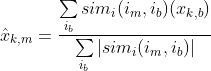

User -Item Similarity : Users who are similar to you also liked
Similarity values between users are measured by observing all the items that are rated by both users.
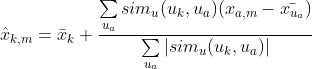

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
df_train, df_test = train_test_split(df_ratings, test_size = 0.25,random_state=42)

In [55]:
n_id_from_all = df_ratings['id_from'].unique().shape[0]
n_id_to_all = df_ratings['id_to'].unique().shape[0]
n_id_from_all, n_id_to_all

(135359, 168791)

In [56]:
n_id_from = df_ratings_sample['id_from'].unique().shape[0]
n_id_to = df_ratings_sample['id_to'].unique().shape[0]
n_id_from, n_id_to

(15874, 12459)

In [57]:
df_ratings_sample['id_to'].unique().shape[0]

12459

In [58]:
df_ratings_sample.shape, df_train.shape, df_test.shape

((4738218, 3), (13019509, 3), (4339837, 3))

In [59]:
for line in df_ratings_sample.itertuples():
    print(line)
    break

Pandas(Index=0, id_from=1, id_to=133, rating=8)


In [60]:
train_data_mat = np.zeros((n_id_from, n_id_to))
train_data_mat.shape

(15874, 12459)

In [61]:
df_test.shape

(4339837, 3)

In [62]:
#Create two user-item matrix, one for training and another for testing
train_data_mat = np.zeros((n_id_from, n_id_to))
# Фильтрация данных для исключения недопустимых индексов
valid_indices = df_train['id_from'].isin(range(1, n_id_from + 1)) & df_train['id_to'].isin(range(1, n_id_to + 1))
filtered_df_train = df_train[valid_indices]
#itertuples gives you content of the row along with it's index
for line in filtered_df_train.itertuples():
  #line[1] - 1 is used to account for index to start from 0, so we get value like
  #train_data_mat[id_from,id_to] = Rating
    train_data_mat[line[1]-1, line[2] -1] = line[3]
test_data_mat = np.zeros((n_id_from, n_id_to))
for line in df_test.itertuples():
    if line[2] in range(1, n_id_to + 1) and line[1] in range(1, n_id_from + 1):
        test_data_mat[line[1]-1, line[2]-1] = line[3]

In [69]:
test_data_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In recommendation system, we commonly use cosine matrix which will treat the ratings given by a specific user as a vector assuming all the null values as 0 rating and then the cosine gives you the measure of similarity as we know cos(0) = 1 so a value of 1 means the users are very similar.

Cosine similiarity for users a and m can be calculated using the formula below, where you take dot product of the user vector  𝑢𝑘
  and the user vector  𝑢𝑎
  and divide it by multiplication of the Euclidean lengths of the vectors.
  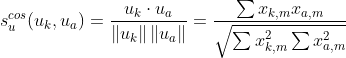

To calculate similarity between items m and b you use the formula:
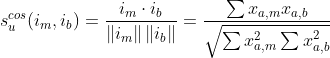

In [63]:
from sklearn.metrics.pairwise import pairwise_distances
id_from_similarity = pairwise_distances(train_data_mat, metric='cosine')
id_to_similarity = pairwise_distances(train_data_mat.T, metric='cosine')

Now we will make prediction based on the similarity of the above calculated matrix. For user based CF, we will use the below formula.
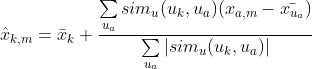
We are subtracting the user mean rating from each rating which would take care of differences between user while rating. Say for example, a user m rates good profile with 8 and the profile he dislikes with 2 and similarly other user a rates movies he likes with 10 and other movies 4. Now both the users have similar taste but they rate differently. After removing the average rating of a user, we also need to normalize so the rating doesn't cross 10. For this we have divided with the

And for item based CF, we will use the below mentioned formula:
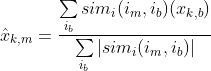

In [64]:
def predict(ratings, similarity, type='user'):
    if type == 'id_from':
        mean_ratings_from = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_ratings_from[:, np.newaxis]) 
        rate_pred = mean_ratings_from[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'id_to':
        rate_pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return rate_pred

In [65]:
id_to_prediction = predict(train_data_mat, id_to_similarity, type='id_to')
id_from_prediction = predict(train_data_mat, id_from_similarity, type='id_from')

In [70]:
print(id_to_prediction)

[[0.01095278 0.01064682 0.01091668 ... 0.01092626 0.01091668 0.01091668]
 [0.00386852 0.00382597 0.00385295 ... 0.00385633 0.00385295 0.00385295]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00241782 0.00240369 0.00240809 ... 0.0024102  0.00240809 0.00240809]
 [0.0047484  0.00484064 0.00489645 ... 0.00485605 0.00489645 0.00489645]
 [0.0013701  0.00132426 0.00136459 ... 0.00136578 0.00136459 0.00136459]]


In [71]:
print(id_from_prediction)

[[ 9.11246241e-03  1.47259169e-02  7.82102114e-03 ...  9.63165107e-03
   7.82102114e-03  7.82102114e-03]
 [ 1.97774881e-03  7.64277748e-03  7.07691439e-04 ...  2.48577176e-03
   7.07691439e-04  7.07691439e-04]
 [-1.90337152e-03  3.76663415e-03 -3.16337278e-03 ... -1.39937101e-03
  -3.16337278e-03 -3.16337278e-03]
 ...
 [ 5.24531076e-04  6.08184844e-03 -7.46126747e-04 ...  1.03279421e-03
  -7.46126747e-04 -7.46126747e-04]
 [ 2.81723263e-03  8.65537171e-03  1.75805455e-03 ...  3.46052821e-03
   1.75805455e-03  1.75805455e-03]
 [-5.19039396e-04  5.03381722e-03 -1.78238437e-03 ... -1.37014050e-05
  -1.78238437e-03 -1.78238437e-03]]


In [79]:
def predi(ratings, similarity, type='user', uid=None):
    if type == 'id_from':
        mean_ratings_from = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_ratings_from[:, np.newaxis])
        rate_pred = mean_ratings_from[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'id_to':
        rate_pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    
    # Возвращаем индексы `id_to`, которым будет поставлена оценка больше 6
    return np.where(rate_pred > 6)[1]


# Запрашиваем у пользователя ввод id пользователя
user_id = int(input("Введите id пользователя: "))

# Убедимся, что введенное значение находится в допустимом диапазоне
if not 1 <= user_id <= df_ratings['id_from'].max():
    print("Ошибка: введенное значение id пользователя вне допустимого диапазона.")
    exit()

# Вызываем функцию predi с введенным значением id пользователя
id_to_prediction = predi(train_data_mat, id_to_similarity, type='id_to', uid=user_id)
id_from_prediction = predi(train_data_mat, id_from_similarity, type='id_from', uid=user_id)

# Ограничиваем вывод до 10 элементов
print("Предсказанные id_to, которым будет поставлена оценка выше 6:")
for i in range(min(10, len(id_to_prediction))):
    print(id_to_prediction[i])

print("Предсказанные id_from, которым будет поставлена оценка выше 6:")
for i in range(min(10, len(id_from_prediction))):
    print(id_from_prediction[i])

# Теперь используем функцию `predict` для получения `id_to`
#id_to_prediction = predict2(train_data_mat, id_to_similarity, type='id_to')
#id_from_prediction = predict2(train_data_mat, id_from_similarity, type='id_from')

Введите id пользователя: 98447
Предсказанные id_to, которым будет поставлена оценка выше 6:
Предсказанные id_from, которым будет поставлена оценка выше 6:
